# Data Gathering

### programmatically downloaded using the Requests library

In [199]:
#import libraries
import requests
import pandas as pd
import json
import datetime as dt
import matplotlib.pyplot as plt

In [ ]:
#store file to file handler
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
code = r.status_code
print(code)
#save downloaded file to local folder
open('image-predictions.tsv', 'wb').write(r.content)



### Download tweet ID, retweet count, and favorite count using Tweepy API

In [ ]:
#read twitte IDs

#read the twitter-archive-enhanced.csv file in to dataframe
df_1 = pd.read_csv('twitter-archive-enhanced.csv')
df_1
#convert the first column of the datafram(tweet id) to a list
IDlist = df_1['tweet_id'].tolist()
IDlist

In [ ]:
#pull twitter status json from twitter API and store them into a list
import tweepy

# key and token omitted for privacy
consumer_key = '*'
consumer_secret = '*'
access_token = '*'
access_secret = '*'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit  = True, wait_on_rate_limit_notify = True)

tweet_list = []

for tid in IDlist:
    try:
        tweet = api.get_status(tid, tweet_mode='extended')
        tweet_list.append(tweet._json)
    except:
        print('tweet ' + str(tid) + "doesn't" exist')



In [ ]:
#check if all tweet status has been downloaded
len(tweet_list)

In [ ]:
# write json to txt file

# type(tweet_json)
with open('tweet_json.txt', 'w') as outfile:
    for tweet_json in tweet_list:
        json.dump(tweet_json, outfile)
        outfile.write('\n') #add a newline character at the end of each json

In [ ]:
# read json from text

tweet_df_raw = pd.read_json('tweet_json.txt', lines = 'True')
tweet_df = tweet_df_raw[['id', 'retweet_count', 'favorite_count']]

# Data Assessing

In [ ]:
#load 3 dataframes from different sources
archive_df = pd.read_csv('twitter-archive-enhanced.csv')
image_df = pd.read_csv('image-predictions.tsv', sep='\t')
status_df = tweet_df.copy()
status_df.rename(columns = {"id": "tweet_id"}, inplace = True)

In [ ]:
status_df

In [ ]:
archive_df.info()
archive_df.sample()
type(archive_df.timestamp)

In [ ]:
archive_df.rating_denominator.value_counts()

issues in archive dataframe
1. Quality issues:
    - Retweets: some of the tweets in this dataframe are retweet, as mentioned in the project detail. These retweet are not supposed to be included in the analysis
    - Unnecessary information: text, sources are not needed for analysis. Retweeted_status_id and retweeted_status_user_id, and retweetd_status_timestamp are not needed after data cleaning procedure. 
    - The rating_numerator and rating_denominator can be combined into one column in decimal form.
    - Wrong data type for tweet id. Since no calculations will be applied on tweet ID, the tweet ID needs to be str instead of int64.
    - The timestamp column has wrong data type. 
2. Tidiess issues
    - Dog stages are not in one column, instead, they are divided into 4.
    - Date and time should be two variables for the purpose of analysis. 

In [ ]:
image_df.info()
image_df.p1.value_counts()
#image_df.sample()

issues in image dataframe
1. Quality issues:
    - Non-descriptive column headers: p1, p1_conf, p1_dog, p2, p2_dog, p3, p3_conf, p3_dog etc. 
    - Some of the dog breeds has first letter capitalized and some are not. 
    - Some of the dog breeds are misspelled (ie. 19 of the breeds is website) or intended misspelled (ie. cheeseburger) 
    
2. Tidiess issues

In [ ]:
status_df.info()

issues in status dataframe
1. Quality issues:
    - wrong data type for tweet ID
2. Tidiess issues

### Summary
Quality issues:
    1. Retweets: some of the tweets in this dataframe are retweet. as mentioned in the project detail, These retweets are not supposed to be included in the analysis.
    2. Unnecessary information: text, sources are not needed for analysis. Retweeted_status_id and retweeted_status_user_id, and retweetd_status_timestamp are not needed after data cleaning procedure. 
    3. Wrong data type for tweet id. Since no calculations will be applied on tweet ID, the tweet ID needs to be str instead of int64.
    4. The timestamp column has wrong data type. 
    5. Non-descriptive column headers: p1, p1_conf, p1_dog, p2, p2_dog, p3, p3_conf, p3_dog etc. 
    6. Some of the dog breeds has first letter capitalized and some are not. 
    7. Many ratings' denominator are not 10, even the numerator which greater than 10 is the feature of this twitter account, keep the denominator same is vital to later analysis. 
    8. Date and time are in the same column, this is not necessarily a tidyness issue, because its nothing wrong with putting this two in same column. It still need tobe parsed because we will perfome analysis around date and time later. 

Tidyness issues:
    1. One observation unit does not form a table. At least, retweet_count and favorite_count needs to be part of the archive dataframe to form a complete observation unit. 
    2. Dog stages are not in one column, instead, they are divided into 4.

# Data Cleaning

Issue #1 : retweets

#### Define:
Remove all tweet rows that has nonnull value in retweeted_status_id column in archive dataframe.

#### Code

In [ ]:
# create a copy
archive_df_clean = archive_df.copy()

# only keep tweet whose retweeted_status_id is NAn
archive_df_clean = archive_df_clean[archive_df_clean['retweeted_status_id'].isnull()]

#### Test

In [ ]:
archive_df_clean.info()

Issue #2: Unnecessary information
#### Define:
Remove columns: expanded_urls, in_reply_to_status_id, in_reply_to_user_id, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, source. 

#### Code

In [ ]:
# Drop unwanted columns
archive_df_clean = archive_df_clean.drop(columns=['expanded_urls', 'in_reply_to_status_id', 'in_reply_to_user_id', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'source'])

#### Test

In [ ]:
list(archive_df_clean)

Issue #3: Wrong datatype for tweet ID
#### Define:
Change data type of Tweet ID to string

#### Code

In [ ]:
# change the datatype of tweet_id
archive_df_clean['tweet_id'] = archive_df_clean['tweet_id'].astype(str)
# change the datatype of tweet_id column in status_df as well
status_df['tweet_id'] = status_df['tweet_id'].astype(str)



#### Test

In [ ]:
archive_df_clean.info()

Issue #4: Wrong datatype for time stamp column
#### Define:
Remove columns: change the timestamp column to 

#### Code

In [ ]:
#analysis the timestamp column
type(archive_df_clean['timestamp'])

archive_df_clean.head(100)

In [ ]:
# single out first 19 digits of the timestamp
archive_df_clean['timestamp'] = archive_df_clean.timestamp.str[:19]

archive_df_clean['timestamp'] = pd.to_datetime(archive_df_clean['timestamp'], format = "%Y-%m-%d %H:%M:%S")

In [ ]:
archive_df_clean.head(100)

#### Test

In [ ]:
archive_df_clean.info()

Issue #5: Non-Descriptive column header in image dataframe
#### Define:
change following column headers:

- p1 -> prediction_1
- p1_conf -> prediction_1_confidence
- p1_dog -> prediction_1_result
- p2 -> prediction_2
- p2_conf -> prediction_2_confidence
- p2_dog -> prediction_2_result
- p3 -> prediction_3
- p3_conf -> prediction_3_confidence
- p3_dog -> prediction_3_result
#### Code

In [ ]:
image_df_clean = image_df.copy()
image_df_clean.rename(columns={'p1': 'prediction_1', 'p1_conf': 'prediction_1_confidence', 'p1_dog': 'prediction_1_result'}, inplace=True)
image_df_clean.rename(columns={'p2': 'prediction_2', 'p2_conf': 'prediction_2_confidence', 'p2_dog': 'prediction_2_result'}, inplace=True)
image_df_clean.rename(columns={'p3': 'prediction_3', 'p3_conf': 'prediction_3_confidence', 'p3_dog': 'prediction_3_result'}, inplace=True)

#### Test

In [ ]:
image_df_clean.sample(100)

Issue #6: the first letter of all dog names are not all capitalized.
#### Define:
capitalize the first letter of all dog breeds

#### Code

In [ ]:
image_df_clean.prediction_1 = image_df_clean.prediction_1.str.title()
image_df_clean.prediction_2 = image_df_clean.prediction_2.str.title()
image_df_clean.prediction_3 = image_df_clean.prediction_3.str.title()


#### Test

In [ ]:
image_df_clean.sample(100)

Issue #7: Many ratings' denominator are not 10
#### Define:
Scale tweets who's denominators more than 10 or less than 10 to 10

#### Code

In [ ]:
archive_df_clean.info()
archive_df_clean.rating_denominator.value_counts()

In [ ]:
for index, row in archive_df_clean.iterrows():
    if row['rating_denominator'] == 0:
        new_denominator = 10
        archive_df_clean.set_value(index, 'rating_denominator', new_denominator)
    elif row['rating_denominator'] != 10:
        print(row['tweet_id'])
        new_denominator = 10
        new_numerator = round((row['rating_numerator']/row['rating_denominator'])*10, 1)
        print(row['rating_denominator'])
        print(new_denominator)
        print(row['rating_numerator'])
        print(new_numerator)
        archive_df_clean.set_value(index, 'rating_denominator', new_denominator)
        archive_df_clean.set_value(index, 'rating_numerator', new_numerator)
#     else:
#         new_denominator = rating_denominator
#         new_numerator = rating_numerator
    

#### Test

In [ ]:
archive_df_clean.rating_denominator.value_counts()

Issue #8: date and time are in one column
#### Define:
seperate date and time into two columns for easier visualization regards the time in a day.

#### Code

In [ ]:
archive_df_clean['date'] = archive_df_clean['timestamp'].apply(lambda time: time.strftime('%m-%d-%Y'))
archive_df_clean['time'] = archive_df_clean['timestamp'].apply(lambda time: time.strftime('%H:%M'))

#### Test

In [ ]:
archive_df_clean

tidyness issue #1: dog stages not in one column
#### Define
combine doggo, floofer, pupper and puppo columns into stage column

#### Code



In [ ]:
archive_df_clean

In [ ]:
archive_df_clean_stage = archive_df_clean.copy()

archive_df_clean_stage["stage"] = ""

for index, row in archive_df_clean_stage.iterrows():
    if row["doggo"]  == "doggo":
        #print(row["doggo"])
        archive_df_clean_stage.loc[index, "stage"] = "doggo"
        
    elif row["floofer"] == "floofer":
        #print(row["floofer"])
        archive_df_clean_stage.loc[index, "stage"] = "floofer"
        
    elif row["pupper"] == "pupper":
        archive_df_clean_stage.loc[index, "stage"] = "pupper"
        
    elif row["puppo"] == "puppo":
        archive_df_clean_stage.loc[index, "stage"] = "puppo"
        
    else:
        archive_df_clean_stage.loc[index, "stage"] = "N/A"

#drop 4 original columns which contains the stage of dogs
#archive_df_clean_stage.drop(["doggo", "floofer", "pupper", "puppo"], axis = 1)        
archive_df_clean = archive_df_clean_stage.copy()
archive_df_clean = archive_df_clean.drop(["doggo", "floofer", "pupper", "puppo"], axis = 1)

#### Test

In [ ]:
archive_df_clean["stage"].sample(10)

In [ ]:
archive_df_clean.sample(10)

tidyness issue #2: observation unit are not in same column
#### Define
inner join three dataframe by twitter ID to forme the observation unit.

#### Code

In [ ]:
type()

In [287]:
#twitter_df_final = pd.concat([archive_df_clean, status_df, image_df_clean], axis=1, join='inner')
#create a copy of image_df which has only tweet_id and related data on prediction 1.
image_df_tomerge = image_df_clean.loc[:, ['tweet_id', 'prediction_1', 'prediction_1_confidence','prediction_1_result']]
image_df_tomerge['tweet_id'] = image_df_tomerge['tweet_id'].astype(str)
twitter_df_merged = pd.merge(pd.merge(archive_df_clean, status_df, on='tweet_id'), image_df_tomerge, on='tweet_id')#pd.merge(status_df, image_df_clean, on = 'tweet_id', how='inner')

#### Test

In [288]:
twitter_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 13 columns):
tweet_id                   1994 non-null object
timestamp                  1994 non-null datetime64[ns]
rating_numerator           1994 non-null int64
rating_denominator         1994 non-null int64
name                       1994 non-null object
date                       1994 non-null object
time                       1994 non-null object
stage                      1994 non-null object
retweet_count              1994 non-null int64
favorite_count             1994 non-null int64
prediction_1               1994 non-null object
prediction_1_confidence    1994 non-null float64
prediction_1_result        1994 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 204.5+ KB


# Store data


In [ ]:
twitter_df_merged.to_csv('twitter_archive_master.csv')

# Analysis and Visualization

In [176]:
twitter_df_merged

,tweet_id,timestamp,rating_numerator,rating_denominator,name,date,time,stage,retweet_count,favorite_count,prediction_1,prediction_1_confidence,prediction_1_result
0,892420643555336193,2017-08-01 16:23:56,13,10,Phineas,08-01-2017,16:23,N/A,8758,39245,Orange,0.097049,False
1,892177421306343426,2017-08-01 00:17:27,13,10,Tilly,08-01-2017,00:17,N/A,6422,33609,Chihuahua,0.323581,True
2,891815181378084864,2017-07-31 00:18:03,12,10,Archie,07-31-2017,00:18,N/A,4265,25317,Chihuahua,0.716012,True
3,891689557279858688,2017-07-30 15:58:51,13,10,Darla,07-30-2017,15:58,N/A,8849,42611,Paper_Towel,0.170278,False
4,891327558926688256,2017-07-29 16:00:24,12,10,Franklin,07-29-2017,16:00,N/A,9631,40774,Basset,0.555712,True
5,891087950875897856,2017-07-29 00:08:17,13,10,None,07-29-2017,00:08,N/A,3206,20444,Chesapeake_Bay_Retriever,0.425595,True
6,890971913173991426,2017-07-28 16:27:12,13,10,Jax,07-28-2017,16:27,N/A,2124,11987,Appenzeller,0.341703,True
7,890729181411237888,2017-07-28 00:22:40,13,10,None,07-28-2017,00:22,N/A,19374,66310,Pomeranian,0.566142,True
8,890609185150312448,2017-07-27 16:25:51,13,10,Zoey,07-27-2017,16:25,N/A,4362,28058,Irish_Terrier,0.487574,True
9,890240255349198849,2017-07-26 15:59:51,14,10,Cassie,07-26-2017,15:59,doggo,7604,32303,Pembroke,0.511319,True


## Insights #1

### Breeds: Most Popular vs Most loved

Assume the neural network predicted breeds right, which dog breeds get rated most? which dog breeds gets most favorite? Are they the same?


In [ ]:
twitter_df_merged.head(5)

In [155]:
#select only predictions where the result is a breed of dogs
prediction_true = twitter_df_merged[twitter_df_merged['prediction_1_result'] == True]

#find the top20 most popular breeds and return its associated data
top20 = prediction_true['prediction_1'].value_counts().head(20).index
top20_df = twitter_df_merged.loc[twitter_df_merged.prediction_1.isin(top20)]

#find the mean favorites for this top 20 most tweeted dog breeds
fav_summary = top20_df.groupby('prediction_1', as_index=False).mean().sort_values('favorite_count')

In [161]:
top20_mostfav = fav_summary[['prediction_1', 'favorite_count']]

In [283]:
top20_mosttweeted = top20_df['prediction_1'].value_counts()
top20_mosttweeted = pd.DataFrame(top20_mosttweeted).reset_index()
top20_mosttweeted.columns = ['prediction_1', 'tweet_count']

In [284]:
#sort two dataframes
top20_mostfav = top20_mostfav.sort_values(by='favorite_count', ascending=False).copy()
top20_mosttweeted = top20_mosttweeted.sort_values(by='tweet_count', ascending=False).copy()

In [339]:
#combine these two dataframs together, prepare for plot
top20_merged = pd.merge(top20_mostfav, top20_mosttweeted, on='prediction_1')
top20_merged = top20_merged.sort_values('tweet_count', ascending = False).copy()
display(top20_merged)
top20_merged.to_csv('top20_merged.csv')

,prediction_1,favorite_count,tweet_count
2,Golden_Retriever,12222.848921,139
4,Labrador_Retriever,11714.042105,95
6,Pembroke,11316.784091,88
12,Chihuahua,8711.734177,79
18,Pug,5871.851852,54
9,Chow,10044.024390,41
1,Samoyed,13449.725000,40
17,Toy_Poodle,6574.973684,38
15,Pomeranian,8051.447368,38
11,Malamute,8725.310345,29


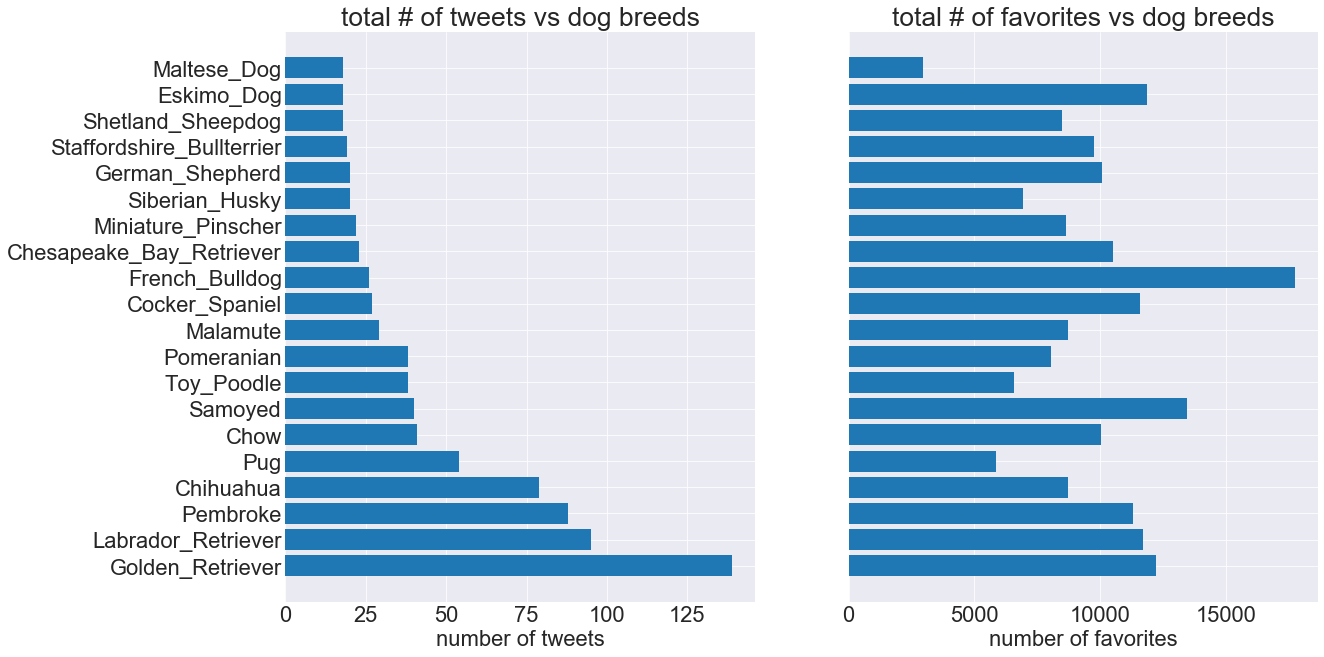

In [319]:
#Make a bar plot of this two table

#set ordered y axis accordin to most tweeted breeds

y = top20_merged['prediction_1']
x = top20_merged['tweet_count']
z = top20_merged['favorite_count']

plt.rc('font', size = 22)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.barh(range(len(y)), x)
plt.yticks(range(len(y)), y)
ax1.set_title('total # of tweets vs dog breeds')
ax1.set(xlabel = 'number of tweets')
ax2.barh(range(len(y)), z)
ax2.set_title('total # of favorites vs dog breeds')
ax2.set(xlabel = 'number of favorites')


f.set_size_inches(18.5, 10.5)
plt.show()

From the plot shown above, we can see even golden retriver has most tweets, french bull dog is the most favorite breeds. However, most of the dogs in top20 most tweeted list are also in most favorites list.

## Insights #2

### Popular dog names

what is the most popular dog names?

In [183]:
twitter_df_merged['name'].value_counts().head(20)
#top20_dognames = pd.DataFrame(top20_dognames)
#top20_mosttweeted = pd.DataFrame(top20_mosttweeted).reset_index()
#top20 = prediction_true['prediction_1'].value_counts().head(20).index
#display(top20_dognames)

None       546
a           55
Charlie     11
Lucy        10
Oliver      10
Cooper      10
Penny        9
Tucker       9
Winston      8
Sadie        8
the          7
Toby         7
Daisy        7
Lola         7
an           6
Jax          6
Bella        6
Koda         6
Bo           6
Stanley      6
Name: name, dtype: int64

Beside "None" and "a" which is apperently not need real dog names, the most popular dog names are Charlie, Lucy, Oliver and Cooper

## Insights #3

### rated "0" dogs

Knowing the WeRateDogs tend to "spoil" their dogs, is there ever a dog receive 0 rating?

In [187]:
twitter_df_merged[twitter_df_merged['rating_numerator'] == 0]

,tweet_id,timestamp,rating_numerator,rating_denominator,name,date,time,stage,retweet_count,favorite_count,prediction_1,prediction_1_confidence,prediction_1_result
235,835152434251116546,2017-02-24 15:40:31,0,10,None,02-24-2017,15:40,N/A,3404,24318,Swing,0.967066,False
756,746906459439529985,2016-06-26 03:22:31,0,10,None,06-26-2016,03:22,N/A,332,3136,Traffic_Light,0.470708,False


Use markdown to display the image.
Appeartly, the first golden retriver truly deserve a 10 and the second image doesn't even a dog.

![alt text](https://pbs.twimg.com/media/C5cOtWVWMAEjO5p.jpg)
![alt text](https://pbs.twimg.com/media/Cl2LdofXEAATl7x.jpg)

## Visualization

### Number of retweets vs time

Is WeRateDogs still popular through these years?
plot the # of retweet against date to see the trend of this account

In [250]:
retweet_sum = twitter_df_merged.groupby('date', as_index = False).sum()
retweet_sum = retweet_sum.sort_values(by = "date", ascending=False)
#change type of date column to datetime
retweet_sum['date'] = pd.to_datetime(retweet_sum['date'], format = "%m-%d-%Y")
#df.groupby(pd.TimeGrouper(freq='M'))
retweet_sum = retweet_sum.sort_values(by = "date")

retweet_sum.set_index('date', inplace=True)

#top20_mosttweeted = top20_mosttweeted.sort_values(by='count', ascending=False)

In [251]:
retweet_sum.sample(3)

,rating_numerator,rating_denominator,retweet_count,favorite_count,prediction_1_confidence,prediction_1_result
date,,,,,,
2017-01-09,23,20,5428,24110,1.366771,1.0
2016-02-28,32,30,2794,8741,2.497052,3.0
2016-10-05,23,20,6252,20924,1.103265,2.0


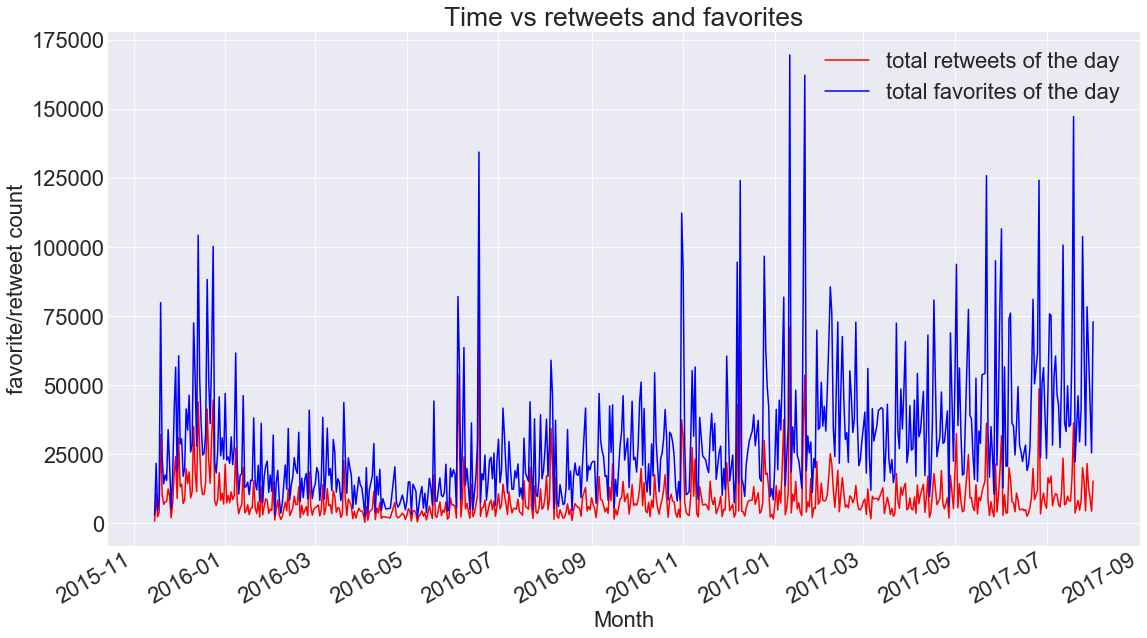

In [338]:



figure_v = plt.figure()

retweet_sum['retweet_count'].plot(color = 'red', label='total retweets of the day')
retweet_sum['favorite_count'].plot(color = 'blue', label='total favorites of the day')
plt.title('Time vs retweets and favorites')
plt.xlabel('Month')
plt.ylabel('favorite/retweet count')
plt.legend()
#plt.savefig('visulization_retweet_favorite_vs_time.pdf')

figure_v.set_size_inches(18.5, 10.5)

plt.show(figure_v)

As shown in the graph above, the general trend of retweets keeps amlost the same through 2015 to 2017 while the favorite keep increasing. Its make sense because total number of favorite can easility accumulated over the time and people tend to not retweet a past tweets.

# reference

1. multiple json in txt line by line: https://stackoverflow.com/questions/17055117/python-json-dump-append-to-txt-with-each-variable-on-new-line
2. load json from txt line by line: https://stackoverflow.com/questions/21533894/how-to-read-line-delimited-json-from-large-file-line-by-line
3. create dataframe from json file: https://stackoverflow.com/questions/47925828/how-to-create-a-pandas-dataframe-using-tweepy
4. keep only rows who has NaN in a certain column: https://stackoverflow.com/questions/25430995/keeping-nan-values-and-dropping-nonmissing-values
5. str to datetime: https://stackoverflow.com/questions/17134716/convert-dataframe-column-type-from-string-to-datetime
6. iterate rows to change value https://stackoverflow.com/questions/23330654/update-a-dataframe-in-pandas-while-iterating-row-by-row
7. use isin
8. combine to different columns into 1: 
9. merge 3 dataframes
https://stackoverflow.com/questions/23668427/pandas-joining-multiple-dataframes-on-columns
10. create empty column(s)
https://stackoverflow.com/questions/16327055/how-to-add-an-empty-column-to-a-dataframe
11. conditional mean
https://stackoverflow.com/questions/44787916/conditional-mean-over-a-pandas-dataframe
12. assign column name to series
https://stackoverflow.com/questions/28503445/assigning-column-names-to-a-pandas-series